In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
from matplotlib import colormaps #type: ignore

task = 'sst2'
sd = 7
epochs = 3

seeds = [7, 42, 357, 618, 1337]
aseeds = [7, 42, 357, 618]
aph = 'avg'
include_random = False
include_large_alpha = False
rand_avg = True
alpha_avg = True

cmp = 'viridis'
include_viridis = False

sv = False
dpi = 500
transparent = False

pth = f'c:/Ebooks/code/Research/Selft/Plots/{task}'
if sv:
    print(os.getcwd())
    pth = os.path.join(os.getcwd(), pth)
    Path(pth).mkdir(parents=True, exist_ok=True)
    print(pth)

In [2]:
x_lim_loss = [0.8, epochs]
y_lim_loss = [0.19, 0.36]
x_lim_acc = [0.8, epochs]
y_lim_acc = [0.85, 0.95]

methods  = {
    "alpha_asc_False": ['Training Larger Alpha Layers First','large_alph'],
    "alpha_asc_True": ['Training Smaller Alpha Layers First','small_alph'],
    "layer_asc_False": ['Training Bottom Layers First','bottom_first'],
    "layer_asc_True": ['Training Top Layers First','top_first'],
    "layer_asc_rand": ['Training Random Layers ', 'random'],
}

for key, value in methods.items():
    if not include_viridis:
        break
    plt.figure(figsize=(20, 3))
    first_val_loss = []
    first_val_acc = []

    layers = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 18, 24, 30, 36, 72, 74]
    cmap = colormaps[cmp]
    # cmap =  get_cmap(cmp, len(layers)))

    for l_idx, layer in enumerate(layers):
        
        base_path = f"GLUE/trainseed_{sd}/task_{task}/lay_norm_False/{key}/layers_{layer}/lr2e-5_epoch3_bs32/"
        
        path = os.path.join(base_path, 'baseline.npy')
        
        alpha_vals = []
        for epoch in range (0, epochs, 1):
            csv_path = os.path.join(base_path, 'stats', f'epoch_{epoch}.csv')
            df = pd.read_csv(csv_path)
            alpha_vals.append(np.mean(df['alpha'][2:]))

        baseline = np.load(path, allow_pickle=True).item()
        first_val_loss.append(baseline['val_loss_base'])
        first_val_acc.append(baseline['val_acc_base'])
        
        plt.subplot(1, 5, 1)
        plt.plot(baseline['val_loss_base'], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
        plt.xlabel('Train Epochs')
        plt.title('Validation Loss')
        
        plt.subplot(1, 5, 2)
        plt.plot(baseline['val_loss_base'][:], label = f'Layers={layer}', c=cmap(l_idx/len(layers)))
        plt.xlim(x_lim_loss)
        plt.ylim(y_lim_loss)
        plt.title('Validation Loss (Zoomed)')
        
        plt.subplot(1, 5, 3)
        plt.plot(baseline['val_acc_base'], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
        plt.xlabel('Train Epochs')
        plt.title('Validation Accuracy')
        
        plt.subplot(1, 5, 4)
        plt.plot(baseline['val_acc_base'][:], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
        plt.xlim(x_lim_acc)
        plt.ylim(y_lim_acc)
        plt.title('Validation Accuracy (Zoomed)')
        
        plt.subplot(1, 5, 5)
        plt.plot(alpha_vals[:], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
        plt.xlabel('Train Epochs')
        plt.legend(bbox_to_anchor=(1, 1))
        plt.title('Alpha')
        
    plt.suptitle(f'{value[0]} ({task})', fontsize=12, y=1.1)
    if sv:
        plt.savefig(f'{pth}/{value[1]}.png', transparent=transparent, dpi=dpi, bbox_inches='tight')

In [3]:
dictionary = {
    "alpha_asc_False": {"first_val_loss": [], "first_val_acc": [], "alpha_vals": []},
    # "alpha_asc_True": {"first_val_loss": [], "first_val_acc": [], "alpha_vals": []},
    # "layer_asc_False": {"first_val_loss": [], "first_val_acc": [], "alpha_vals": []},
    # "layer_asc_True": {"first_val_loss": [], "first_val_acc": [], "alpha_vals": []},
    # "layer_asc_rand": {"first_val_loss": [], "first_val_acc": [], "alpha_vals": []},
    # "autolora_asc_rand" : {"first_val_loss": [], "first_val_acc": [], "alpha_vals": []},
}

for key in dictionary:
    
    layers = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 18, 24, 30, 36, 72, 74]
    cmap = colormaps[cmp]

    if 'autolora' in key:
        continue

    for l_idx, layer in enumerate(layers):

        base_path = (
            f"GLUE/trainseed_{sd}/task_{task}/lay_norm_False/{key}/layers_{layer}/lr2e-5_epoch3_bs32/"
        )
        path = os.path.join(base_path, "baseline.npy")
        alpha_vals = []

        for epoch in range(0, epochs, 1):
            stats_path = os.path.join(base_path, "stats", f"epoch_{epoch}.csv")
            df = pd.read_csv(stats_path)
            layers_path = os.path.join(base_path, "stats", f"freeze_{epoch}.csv")
            frozen = pd.read_csv(layers_path)
            frozen =( frozen[frozen["freeze_layer"] == False])
            unfrozen = frozen["name"].tolist()
            unfrozen = [name.rsplit('.', 1)[0] for name in unfrozen]
            alphas = df["alpha"][df["longname"].isin(unfrozen)]
            if aph == 'min':
                alpha_vals.append(np.min(alphas))
            elif aph == 'max':
                alpha_vals.append(np.max(alphas))
            elif aph == 'avg':
                alpha_vals.append(np.mean(alphas))
            else:
                alpha_vals.append(np.mean(df["alpha"][2:]))

        baseline = np.load(path, allow_pickle=True).item()

        dictionary[key]["first_val_loss"].append(baseline["val_loss_base"])

        dictionary[key]["first_val_acc"].append(baseline["val_acc_base"])

        if 'lora' in key:
            dictionary[key]["alpha_vals"].append(alpha_vals[0])
        dictionary[key]["alpha_vals"].append(alpha_vals)

    dictionary[key]["first_val_loss"] = np.array(dictionary[key]["first_val_loss"])  # type: ignore
    dictionary[key]["first_val_acc"] = np.array(dictionary[key]["first_val_acc"])  # type: ignore
    dictionary[key]["alpha_vals"] = np.array(dictionary[key]["alpha_vals"])  # type: ignore

In [4]:
for key in dictionary:
    if 'autolora' in key:
        pth = f"GLUE/trainseed_{sd}/task_{task}/lay_norm_False/{key}/lr2e-5_epoch3_bs32/"
        pth = os.path.join(pth, 'baseline.npy')
    
        lora_base = np.load(pth, allow_pickle=True).item()
    
        dictionary[key]["first_val_loss"].append(lora_base["val_loss_base"])
        dictionary[key]["first_val_acc"].append(lora_base["val_acc_base"])
        dictionary[key]["alpha_vals"].append([0])
    
        dictionary[key]["first_val_loss"] = np.array(dictionary[key]["first_val_loss"])  # type: ignore
        dictionary[key]["first_val_acc"] = np.array(dictionary[key]["first_val_acc"])  # type: ignore
        dictionary[key]["alpha_vals"] = np.array(dictionary[key]["alpha_vals"])  # type: ignore

In [5]:
rdict = {}
for seed in seeds:
    if not include_random and not rand_avg:
        break
    key = f'layer_asc_rand{seed}'
    rdict[key] = {'first_val_loss': [], 'first_val_acc': [], 'alpha_vals': []}
    layers = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 18, 24, 30, 36, 72, 74]
    cmap = colormaps[cmp]

    for l_idx, layer in enumerate(layers):
        base_path = (
            f"GLUE/trainseed_{seed}/task_{task}/lay_norm_False/layer_asc_rand/layers_{layer}/lr2e-5_epoch3_bs32/"
        )
        path = os.path.join(base_path, "baseline.npy")
        alpha_vals = []
        for epoch in range(0, epochs, 1):
            stats_path = os.path.join(base_path, "stats", f"epoch_{epoch}.csv")
            df = pd.read_csv(stats_path)
            layers_path = os.path.join(base_path, "stats", f"freeze_{epoch}.csv")
            frozen = pd.read_csv(layers_path)
            frozen =( frozen[frozen["freeze_layer"] == False])
            unfrozen = frozen["name"].tolist()
            unfrozen = [name.rsplit('.', 1)[0] for name in unfrozen]
            alphas = df["alpha"][df["longname"].isin(unfrozen)]
            if aph == 'min':
                alpha_vals.append(np.min(alphas))
            elif aph == 'max':
                alpha_vals.append(np.max(alphas))
            elif aph == 'avg':
                alpha_vals.append(np.mean(alphas))
            else:
                alpha_vals.append(np.mean(df["alpha"][2:]))

        baseline = np.load(path, allow_pickle=True).item()
        rdict[key]["first_val_loss"].append(baseline["val_loss_base"])
        rdict[key]["first_val_acc"].append(baseline["val_acc_base"])
        rdict[key]["alpha_vals"].append(alpha_vals)

    rdict[key]["first_val_loss"] = np.array(rdict[key]["first_val_loss"])  # type: ignore
    rdict[key]["first_val_acc"] = np.array(rdict[key]["first_val_acc"])  # type: ignore
    rdict[key]["alpha_vals"] = np.array(rdict[key]["alpha_vals"])  # type: ignore

In [6]:
adict = {}
for seed in aseeds:
    if not alpha_avg and not include_large_alpha:
        break
    key = f'alpha_asc_False{seed}'
    adict[key] = {'first_val_loss': [], 'first_val_acc': [], 'alpha_vals': []}
    layers = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 18, 24, 30, 36, 72, 74]
    cmap = colormaps[cmp]

    for l_idx, layer in enumerate(layers):
        base_path = (
            f"GLUE/trainseed_{seed}/task_{task}/lay_norm_False/alpha_asc_False/layers_{layer}/lr2e-5_epoch3_bs32/"
        )
        path = os.path.join(base_path, "baseline.npy")
        alpha_vals = []
        for epoch in range(0, epochs, 1):
            stats_path = os.path.join(base_path, "stats", f"epoch_{epoch}.csv")
            df = pd.read_csv(stats_path)
            layers_path = os.path.join(base_path, "stats", f"freeze_{epoch}.csv")
            frozen = pd.read_csv(layers_path)
            frozen =( frozen[frozen["freeze_layer"] == False])
            unfrozen = frozen["name"].tolist()
            unfrozen = [name.rsplit('.', 1)[0] for name in unfrozen]
            alphas = df["alpha"][df["longname"].isin(unfrozen)]
            if aph == 'min':
                alpha_vals.append(np.min(alphas))
            elif aph == 'max':
                alpha_vals.append(np.max(alphas))
            elif aph == 'avg':
                alpha_vals.append(np.mean(alphas))
            else:
                alpha_vals.append(np.mean(df["alpha"][2:]))

        baseline = np.load(path, allow_pickle=True).item()
        adict[key]["first_val_loss"].append(baseline["val_loss_base"])
        adict[key]["first_val_acc"].append(baseline["val_acc_base"])
        adict[key]["alpha_vals"].append(alpha_vals)

    adict[key]["first_val_loss"] = np.array(adict[key]["first_val_loss"])  # type: ignore
    adict[key]["first_val_acc"] = np.array(adict[key]["first_val_acc"])  # type: ignore
    adict[key]["alpha_vals"] = np.array(adict[key]["alpha_vals"])  # type: ignore

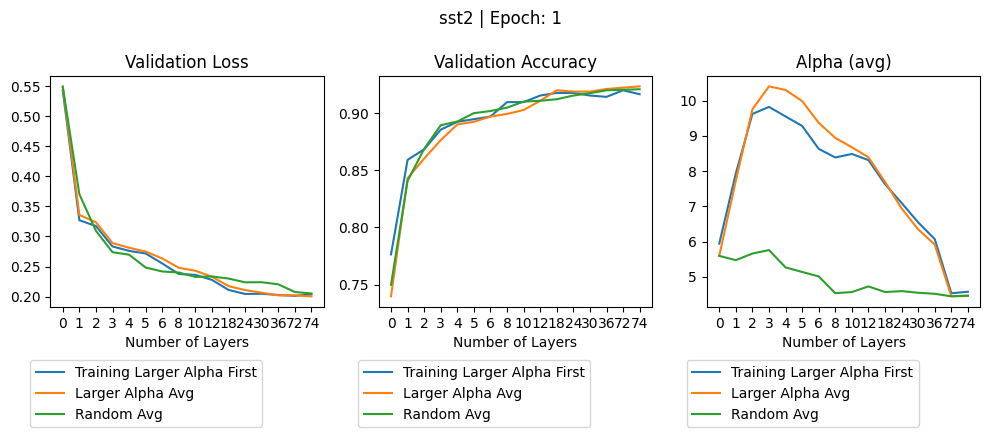

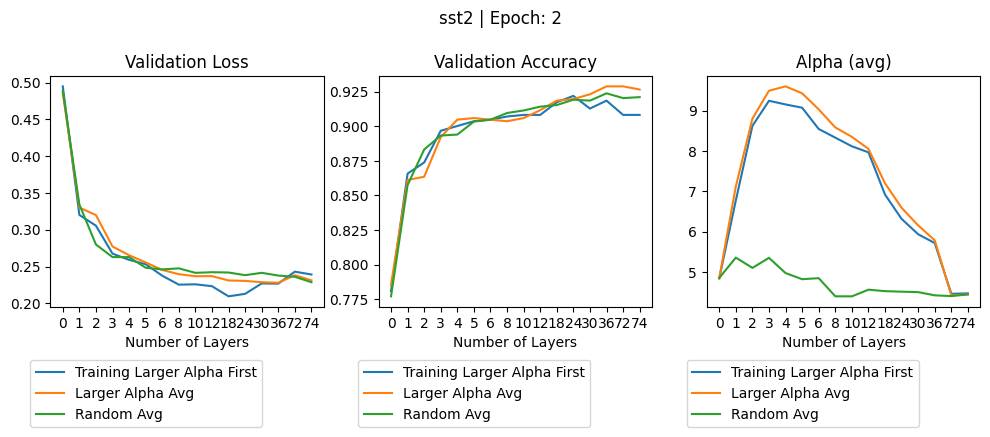

In [7]:
methods = {
    "alpha_asc_False": "Training Larger Alpha First",
    "alpha_asc_True": "Training Smaller Alpha First",
    "layer_asc_False": "Training Bottom First",
    "layer_asc_True": "Training Top First",
    "layer_asc_rand": f"Training Random {sd}",
    "autolora_asc_rand" : "LoRA (default)",
}

layer_cnt = len(layers)
marker_size = 2
show_marker = False
marker = 'o' if show_marker else None

for i in range(1, epochs, 1):
    plt.figure(figsize=(12, 3))

    plt.subplot(1, 3, 1)
    for key in dictionary:
        values = dictionary[key]["first_val_loss"][:, i] # type: ignore
        if 'autolora' in key:
            values = np.full(layer_cnt, values)
        plt.plot(
            range(layer_cnt), values, # type: ignore
            markersize = marker_size,
            marker = marker,
            label=methods[key]
        )
    if include_large_alpha:
        for seed in aseeds:
            plt.plot(
                    range(layer_cnt), adict[f'alpha_asc_False{seed}']["first_val_loss"][:, i], # type: ignore
                    markersize = marker_size,
                    marker = marker,
                    label=f'Large Alpha ({seed})'
            )
    if include_random:
        for seed in seeds:
            plt.plot(
                    range(layer_cnt), rdict[f'layer_asc_rand{seed}']["first_val_loss"][:, i], # type: ignore
                    markersize = marker_size,
                    marker = marker,
                    label=f'Random ({seed})'
            )
    if alpha_avg:
        avg = np.zeros(layer_cnt)
        for seed in aseeds:
            avg += (adict[f"alpha_asc_False{seed}"]["first_val_loss"][:, i])
        avg /= len(aseeds)
        plt.plot(
            range(layer_cnt), avg, # type: ignore
            markersize = marker_size,
            marker = marker,
            label=f'Larger Alpha Avg'
            )
    if rand_avg:
        avg = np.zeros(layer_cnt)
        for seed in seeds:
            avg += (rdict[f"layer_asc_rand{seed}"]["first_val_loss"][:, i])
        avg /= len(seeds)
        plt.plot(
            range(layer_cnt), avg, # type: ignore
            markersize = marker_size,
            marker = marker,
            label=f'Random Avg'
            )
    plt.xticks(range(layer_cnt), layers) # type: ignore
    plt.legend(bbox_to_anchor=(0.8, -0.2))
    plt.xlabel('Number of Layers')
    plt.title('Validation Loss')
    
    plt.subplot(1, 3, 2)
    for key in dictionary:
        values = dictionary[key]["first_val_acc"][:, i] # type: ignore
        if 'autolora' in key:
            values = np.full(layer_cnt, values)
        plt.plot(
            range(layer_cnt), values, # type: ignore
            markersize = marker_size,
            marker = marker,
            label=methods[key]
        )
    if include_large_alpha:
        for seed in aseeds:
            plt.plot(
                    range(layer_cnt), adict[f'alpha_asc_False{seed}']["first_val_acc"][:, i], # type: ignore
                    markersize = marker_size,
                    marker = marker,
                    label=f'Large Alpha ({seed})'
            )
    if include_random:
        for seed in seeds:
            plt.plot(
                    range(layer_cnt), rdict[f'layer_asc_rand{seed}']["first_val_acc"][:, i], # type: ignore
                    markersize = marker_size,
                    marker = marker,
                    label=f'Random ({seed})'
            )
    if alpha_avg:
        avg = np.zeros(layer_cnt)
        for seed in aseeds:
            avg += (adict[f"alpha_asc_False{seed}"]["first_val_acc"][:, i])
        avg /= len(aseeds)
        plt.plot(
            range(layer_cnt), adict[f'alpha_asc_False{seed}']["first_val_acc"][:, i], # type: ignore
            markersize = marker_size,
            marker = marker,
            label=f'Larger Alpha Avg'
            )
    if rand_avg:
        avg = np.zeros(layer_cnt)
        for seed in seeds:
            avg += (rdict[f"layer_asc_rand{seed}"]["first_val_acc"][:, i])
        avg /= len(seeds)
        plt.plot(
            range(layer_cnt), avg, # type: ignore
            markersize = marker_size,
            marker = marker,
            label=f'Random Avg'
            )
    plt.xticks(range(layer_cnt), layers) # type: ignore
    plt.xlabel('Number of Layers')
    plt.title('Validation Accuracy')
    plt.legend(bbox_to_anchor=(0.8, -0.2))
    
    plt.subplot(1, 3, 3)
    for key in dictionary:
        if 'lora' in key:
            continue
        plt.plot(
            range(layer_cnt), dictionary[key]["alpha_vals"][:, i], # type: ignore
            markersize = marker_size,
            marker = marker,
            label=methods[key]
        )
    if include_large_alpha:
        for seed in aseeds:
            plt.plot(
                    range(layer_cnt), adict[f'alpha_asc_False{seed}']["alpha_vals"][:, i], # type: ignore
                    markersize = marker_size,
                    marker = marker,
                    label=f'Large Alpha ({seed})'
            )
    if include_random:
        for seed in seeds:
            plt.plot(
                    range(layer_cnt), rdict[f'layer_asc_rand{seed}']["alpha_vals"][:, i], # type: ignore
                    markersize = marker_size,
                    marker = marker,
                    label=f'Random ({seed})'
            )
    if alpha_avg:
        avg = np.zeros(layer_cnt)
        for seed in aseeds:
            avg += (adict[f"alpha_asc_False{seed}"]["alpha_vals"][:, i])
        avg /= len(aseeds)
        plt.plot(
            range(layer_cnt), avg, # type: ignore
            markersize = marker_size,
            marker = marker,
            label=f'Larger Alpha Avg'
            )
    if rand_avg:
        avg = np.zeros(layer_cnt)
        for seed in seeds:
            avg += (rdict[f"layer_asc_rand{seed}"]["alpha_vals"][:, i])
        avg /= len(seeds)
        plt.plot(
            range(layer_cnt), avg, # type: ignore
            markersize = marker_size,
            marker = marker,
            label=f'Random Avg'
            )
    plt.xticks(range(layer_cnt), layers) # type: ignore
    plt.xlabel('Number of Layers')
    plt.title('Alpha '+ f'({aph.lower()})')
    plt.legend(bbox_to_anchor=(0.8, -0.2))
    
    plt.suptitle(f'{task} | Epoch: {i}', y=1.1)
    
    if sv:
        plt.savefig(f'{pth}/ep{i}.png', transparent=transparent, dpi=dpi, bbox_inches='tight')
    plt.show()